# EDA

# Table of Contents
1. [Packages and Data Importation](#Packages-and-Data-Importation)  
2. [Data Sanity Check](#Data-Sanity-Check)  
3. [Feature Data Types](#Feature-Data-Types)  
4. [Exploring the Numeric Features](#Exploring-the-Numeric-Features)  
5. [Exploring the Numeric vs Non-Numeric Features](#Exploring-the-Numeric-vs-Non-numeric-Features)  
6. [Exploring the Target](#Exploring-the-Target)  
7. [Exploring Time Feature](#Exploring-Time-Feature)  
8. [Outliers](#Outliers)  
9. [Exploring Best Transformations](#Exploring-Best-Transformations)  
10. [Saving Treated Database](#Saving-Treated-Database)  
11. [References](#References) 

# Packages and Data Importation

In [4]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import (
    OneHotEncoder,
    PowerTransformer,
    QuantileTransformer,
)

from src.config import (
    ORIGINAL_DATA,
    CLEAN_DATA,
    PALETTE,
    SCATTER_ALPHA,
    RANDOM_STATE,
    )

from src.data_size_optimization import downcast_columns

from src.eda import (
    check_columns_in_feature_dict,
    plot_violin_box_qq, 
    plot_correlation_heatmap,
    plot_boxplot_by_focal_variable,
    plot_boxplot_cat,
    plot_categories_comparison,
    )


#global options
sns.set_theme(style='dark', palette='colorblind', context='notebook')
pd.set_option('display.max_columns', None)

## <span style="color:red;">Thoughts:</span>
- PCA features should be uncorrelated and scalled.
- Without context for the features, 'Time' should not be used to predict fraud, because it is basically an index of when a transaction occured.
- We will assume that all PCs presented have eigenvalues that are representative and suitable for consideration in the analysis.

The orignal data is available at: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [7]:
# Import data
df = pd.read_csv(ORIGINAL_DATA, compression='zip')

display(df)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# Data Sanity Check

In [9]:
# check if name of columns have issues (e.g. spaces, special characters)
print(df.columns)

print('\nNO ISSUES')

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

NO ISSUES


In [10]:
#Chech duplicated values

# Summarize the number of duplicated rows
print("Number of fully duplicated rows:", df[df.duplicated(keep=False)].shape[0])

#ISSUE DETECTED

df = df.drop_duplicates()

print("\nNumber of fully duplicated rows after treatment:", df[df.duplicated(keep=False)].shape[0])

print('\nNO ISSUES')

Number of fully duplicated rows: 1854

Number of fully duplicated rows after treatment: 0

NO ISSUES


In [11]:
df.info()
print("\nColumns with null values (%):\n", df.isnull().mean()[lambda x: x > 0] * 100)

<class 'pandas.core.frame.DataFrame'>
Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-null  float64
 20  V20     283726 non-null  float64
 21  V21     283726 

In [12]:
df.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [13]:
# check the Target (categoric features)

df['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

## <span style="color:red;">Remarks:</span>
- High imbalance between 'Class' (0 and 1).
- No missing values.
- Only Class is categorical.

## <span style="color:red;">Thoughts:</span>
- Use approaches appropriate for imbalanced data (details in Borgne et al 2022).

# Feature Data Types

In [16]:
feature_dict = {
    'numeric': list(df.columns[~df.columns.isin(['Time','Class'])]),
    'time': ['Time'],
    'target': ['Class'],
    #'object': ['Cabin'],
}

#check if all columns were included
check_columns_in_feature_dict(df , feature_dict)

All good in feature_dict


## Convert Categorical Features to Category Data Type

In [18]:
# Convert columns to category dtype
df[feature_dict['target']] = df[feature_dict['target']].apply(pd.Categorical)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   Time    283726 non-null  float64 
 1   V1      283726 non-null  float64 
 2   V2      283726 non-null  float64 
 3   V3      283726 non-null  float64 
 4   V4      283726 non-null  float64 
 5   V5      283726 non-null  float64 
 6   V6      283726 non-null  float64 
 7   V7      283726 non-null  float64 
 8   V8      283726 non-null  float64 
 9   V9      283726 non-null  float64 
 10  V10     283726 non-null  float64 
 11  V11     283726 non-null  float64 
 12  V12     283726 non-null  float64 
 13  V13     283726 non-null  float64 
 14  V14     283726 non-null  float64 
 15  V15     283726 non-null  float64 
 16  V16     283726 non-null  float64 
 17  V17     283726 non-null  float64 
 18  V18     283726 non-null  float64 
 19  V19     283726 non-null  float64 
 20  V20     283726 non-null  float6

# Exploring the Numeric Features

In [20]:
#reduce sample size to speed up visual EDA
# will keep al Class == 1
df[df['Class'] == 1]
# will sample from Class == 0
df[df['Class'] == 0].iloc[:: 4]

df_reduced_n_size = pd.concat([df[df['Class'] == 1], df[df['Class'] == 0].iloc[:: 3]]).sort_values(by="Time")

df_reduced_n_size.shape

(94891, 31)

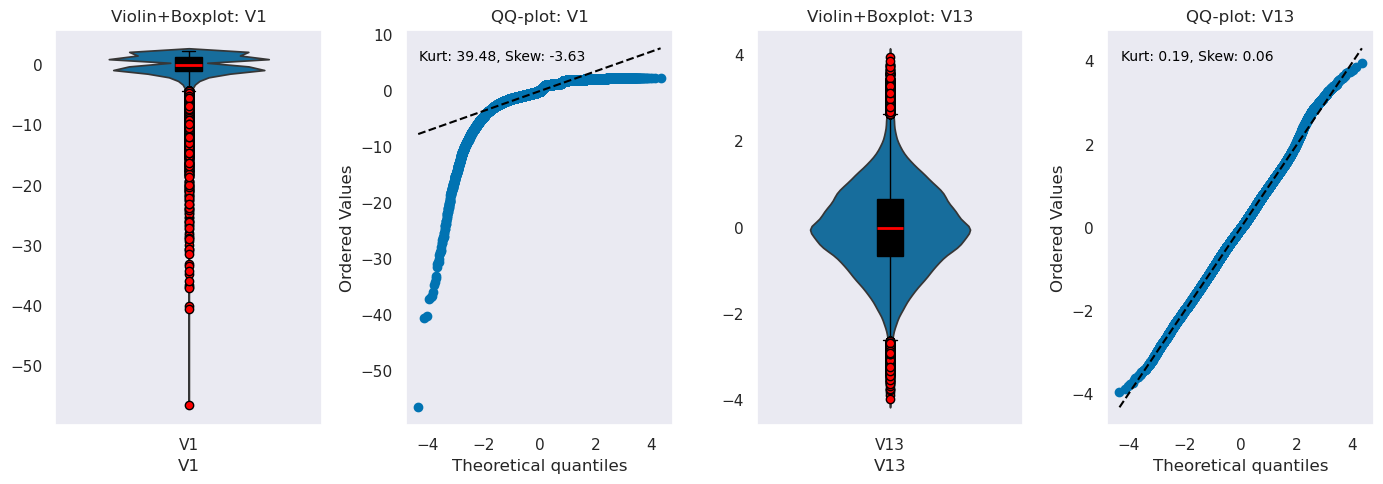

In [84]:
#showing only a few features to ilustrate
plot_violin_box_qq(df_reduced_n_size[['V1','V13']],n_cols_per_row=2)

In [22]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,0.000202,-0.000715,0.000603,0.000252,0.001043,0.001162,0.000170,0.001515,-0.000264,0.000187,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,1.018720,0.994674,0.995430,0.952215,0.914894,0.873696,0.842507,0.837378,0.813379,0.769984,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,-0.761649,-0.406198,-0.647862,-0.425732,-0.581452,-0.466860,-0.483928,-0.498014,-0.456289,-0.211469,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,-0.032306,0.139072,-0.012927,0.050209,0.049299,0.067119,-0.065867,-0.002142,0.003367,-0.062353,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,0.739579,0.616976,0.663178,0.492336,0.650104,0.523512,0.398972,0.501956,0.458508,0.133207,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000


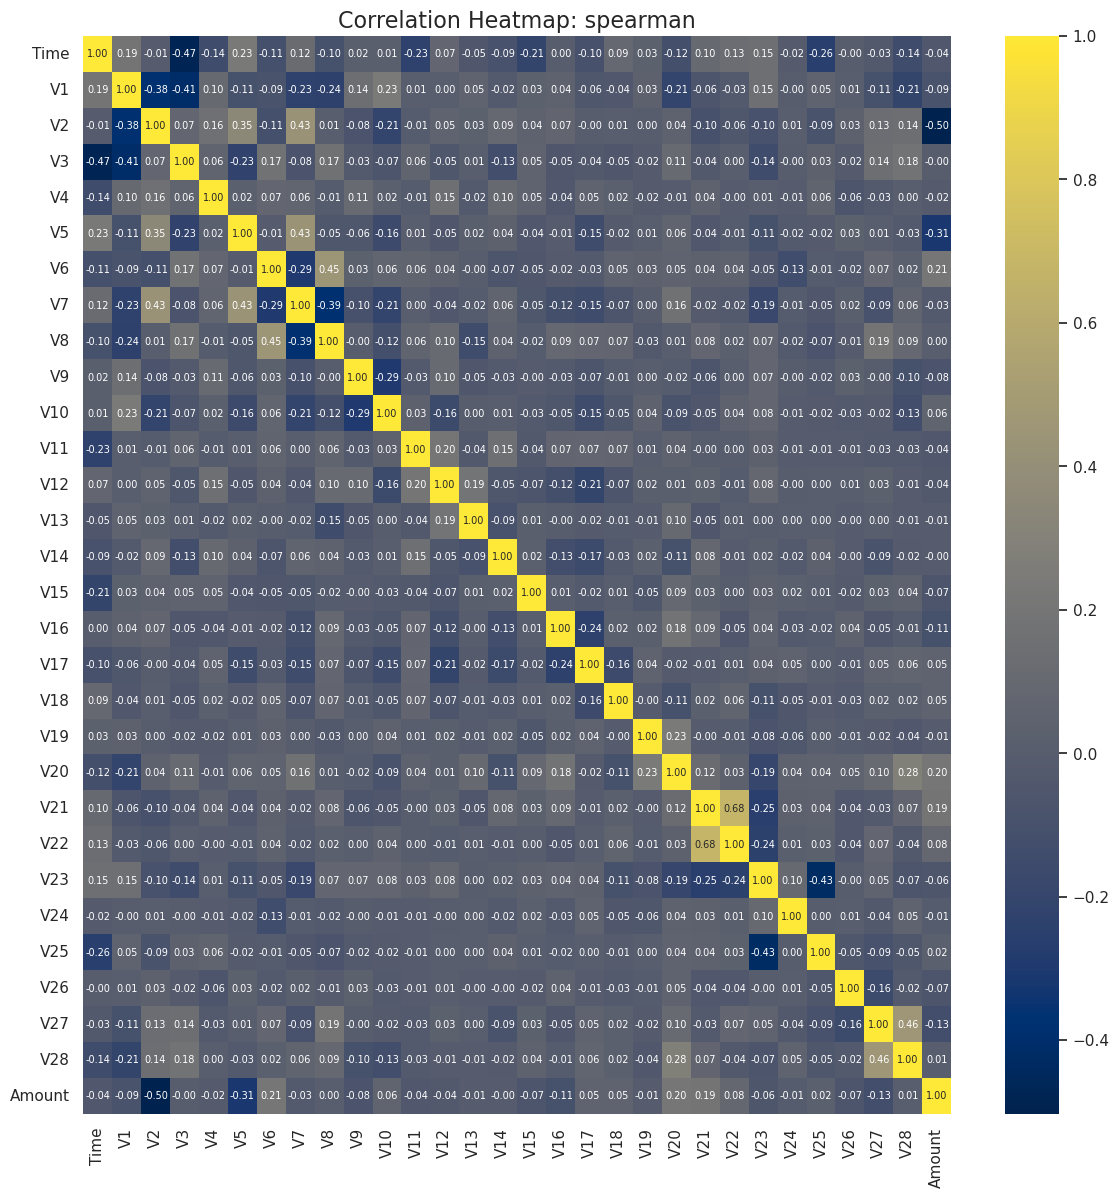

In [23]:
plot_correlation_heatmap(df, cmap=PALETTE, method='spearman', fontsize=7, figsize=(14,14)) #spearman because data is not normal distributed and have several outliers

## <span style="color:red;">Remarks:</span>
- PCA features indeed uncorrelated among them and standardized.
- 'Time' and 'Amount' **are not** standardized.
- Normal distribution: V13 and V15.
- Will accept as normal distribution: V19, V24, V26.
- Amount has low to moderate correlation with V1-V7, V20.
- Outliers are common.

# Exploring the Numeric vs Non-numeric Features

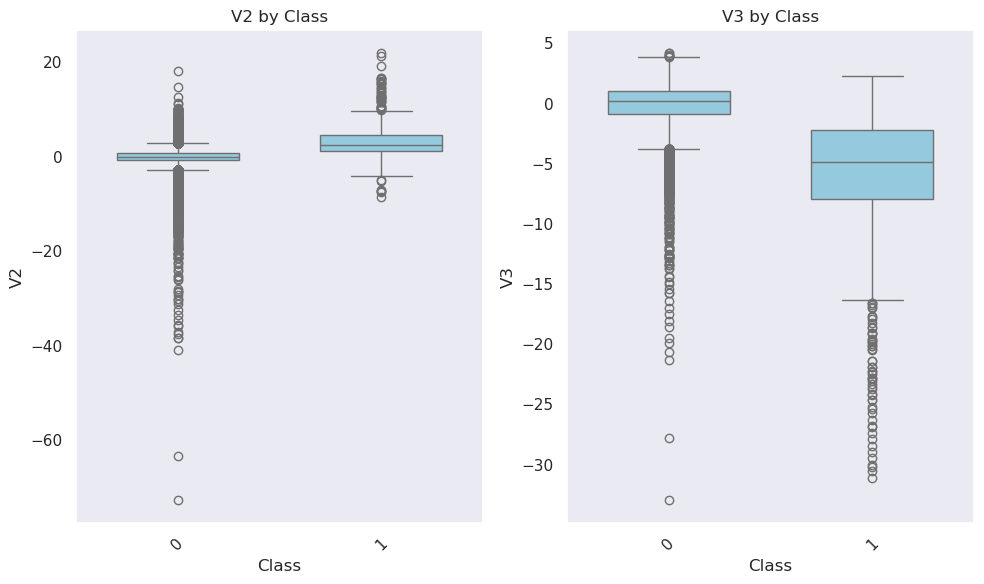

In [26]:
#showing only a few features to ilustrate
plot_boxplot_cat(df_reduced_n_size, feature_dict['target'], [feature_dict['numeric'][1],feature_dict['numeric'][2]],ncols=2)

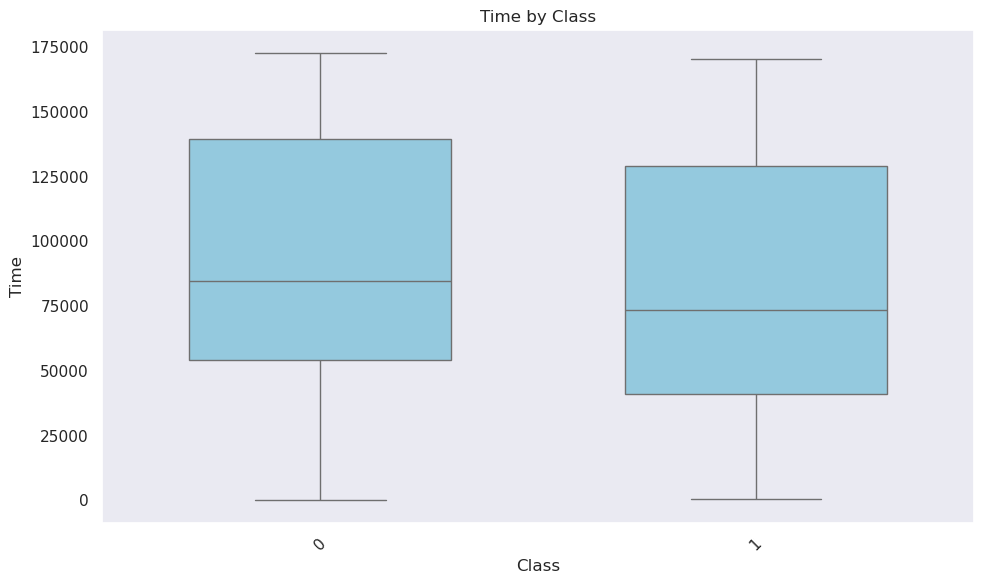

In [27]:
plot_boxplot_cat(df, feature_dict['target'], feature_dict['time'])

## <span style="color:red;">Remarks:</span>
- More nouticeable differences in the first 20 variables.

# Exploring the Target

In [30]:
df.describe(exclude='number')

,Class
count,283726
unique,2
top,0
freq,283253


In [31]:
df['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

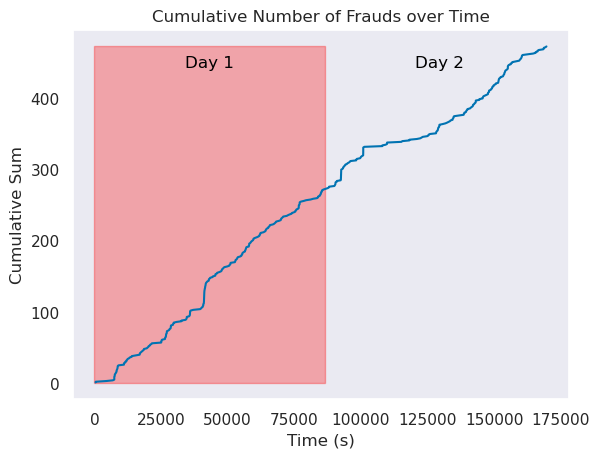

In [32]:
# making a graph to observe how the frauds are distributed over time

# Onehotencoder for encoding and adding 'Time' back to the DataFrame
encoded_df = pd.DataFrame(
    OneHotEncoder(drop='first', sparse_output=False).fit_transform(df[['Class']]),
    columns=['Class_1']
).assign(Time=df['Time'])

# Plot cumulative sum of Class_1 counts over time
cumsum_data = encoded_df[encoded_df['Class_1'] == 1].groupby('Time').size().cumsum()
cumsum_data.plot(kind='line', title='Cumulative Number of Frauds over Time')

# Add rectangle to highlight region from x=0 to x=86400, y=0 to max value
max_y = cumsum_data.max()
plt.gca().add_patch(plt.Rectangle((0, 0), 86400, max_y, color='red', alpha=0.3))
plt.text(43200, 440, 'Day 1', horizontalalignment='center', verticalalignment='bottom', fontsize=12, color='black')
plt.text(43200+86400, 440, 'Day 2', horizontalalignment='center', verticalalignment='bottom', fontsize=12, color='black')
# Labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Sum')
plt.show()

## <span style="color:red;">Remarks:</span>
- Frauds evenly distributed over time.

## <span style="color:red;">Thoughts:</span>
- Use the first day to train and the second day to test the models. The sample does not allow more sophisticated sampling approaches, as proposed in Borgne et al (2022).

# Exploring Time Feature

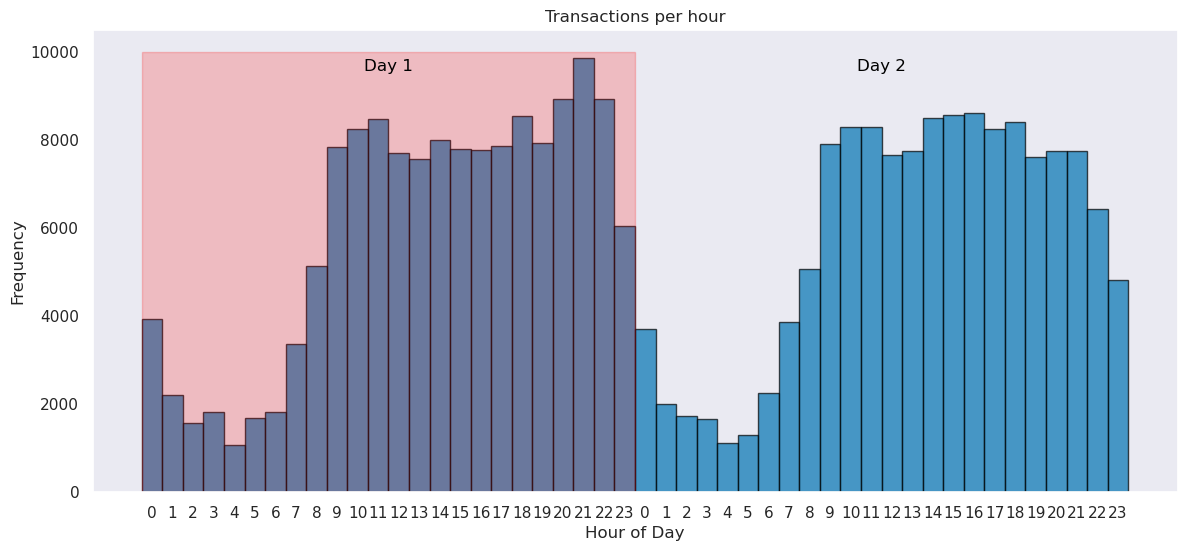

In [35]:
# making a graph of number of transactions per hour

# Define bins (every hour for 48 hours, 3600 seconds = 1 hour)
bins = list(range(0, 172801, 3600))  

df['time_bins'] = pd.cut(df['Time'], bins=bins, right=False)  

frequency = df['time_bins'].value_counts().sort_index()

plt.figure(figsize=(14, 6))   

plt.hist(df['Time'], bins=bins, edgecolor='black', alpha=0.7)

plt.gca().add_patch(plt.Rectangle((0, 0), 86400, 10_000, color='red', alpha=SCATTER_ALPHA))
plt.text(43200, 9500, 'Day 1', horizontalalignment='center', verticalalignment='bottom', fontsize=12, color='black')
plt.text(43200+86400, 9500, 'Day 2', horizontalalignment='center', verticalalignment='bottom', fontsize=12, color='black')

plt.title('Transactions per hour')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')

sequence = list(range(0, 24)) * 2 

bin_centers = [(bin_left + bin_right) / 2 for bin_left, bin_right in zip(bins[:-1], bins[1:])]
plt.xticks(bin_centers, sequence)

plt.show()

## <span style="color:red;">Thoughts:</span>
- I will create a binary category with low (hours 1–6) and high (0, 7–23) transaction amounts.
    - The new feature improved the score by approximately 0.7% (see ah_appendix.ipynb).

In [37]:
#creating the feature
df['Transaction_rate'] = df['time_bins'].apply(lambda x: 'low' if x in frequency[frequency < 3000].index else 'high')

# Convert to category dtype
df['Transaction_rate'] = pd.Categorical(df['Transaction_rate'])

#delete unnecessary objects and features
df = df.drop(columns='time_bins')
del bins, frequency, sequence, bin_centers

feature_dict = {
    'category': ['Transaction_rate'],
    'numeric': list(df.columns[~df.columns.isin(['Time','Class','Transaction_rate'])]),
    'time': ['Time'],
    'target': ['Class'],
}

#check if all columns were included
check_columns_in_feature_dict(df , feature_dict)

All good in feature_dict


# Outliers

## <span style="color:red;">Assumptions:</span>
- Without the context of the variables, I'll assume they represent genuine data.

# Exploring Best Transformations

I will compare PowerTransformer() and QuantileTransformer()

### PowerTransformer

In [42]:
power_transform = PowerTransformer()
df_power_transform = pd.DataFrame(power_transform.fit_transform(df[feature_dict['numeric']]))
df_power_transform.columns = df[feature_dict['numeric']].columns

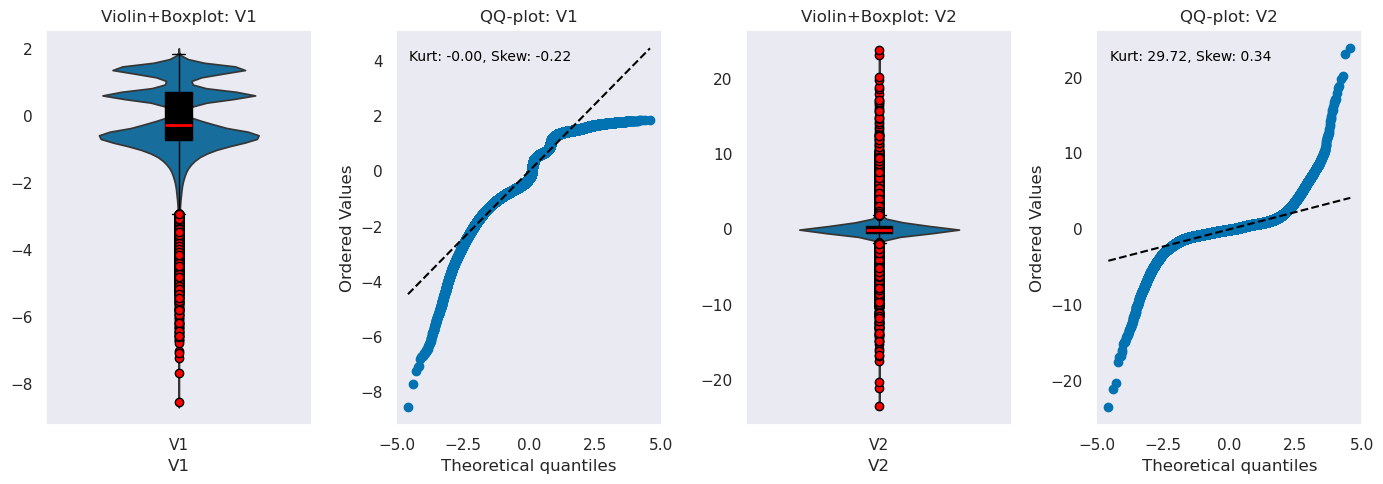

In [43]:
#showing only a few features to ilustrate
plot_violin_box_qq(df_power_transform[['V1','V2']], n_cols_per_row=2)

### QuantileTransformer

In [44]:
quantile_transform = QuantileTransformer(output_distribution='normal', random_state=RANDOM_STATE)
df_quantile_transform = pd.DataFrame(quantile_transform.fit_transform(df[feature_dict['numeric']]))
df_quantile_transform.columns = df[feature_dict['numeric']].columns

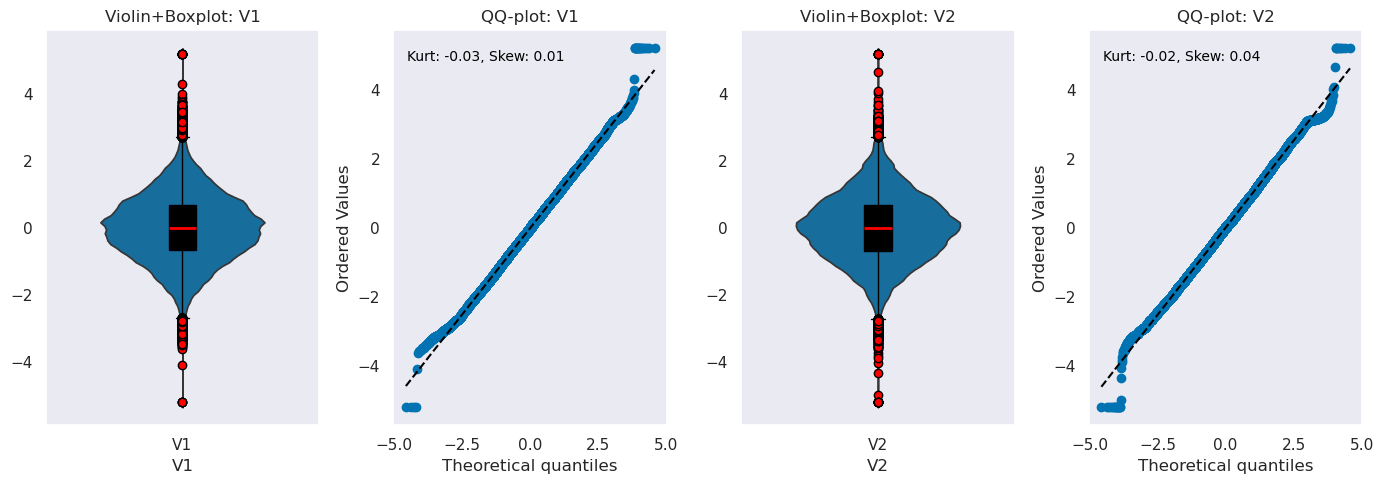

In [45]:
#showing only a few features to ilustrate
plot_violin_box_qq(df_quantile_transform[['V1','V2']], n_cols_per_row=2)

## <span style="color:red;">Thoughts:</span>
- QuantileTransformer performs better.

# Saving Treated Database

## Size optimization

In [49]:
downcast_columns(df)
df.info()

Column: Time, All integers: True
Column: V1, All integers: False
Column: V2, All integers: False
Column: V3, All integers: False
Column: V4, All integers: False
Column: V5, All integers: False
Column: V6, All integers: False
Column: V7, All integers: False
Column: V8, All integers: False
Column: V9, All integers: False
Column: V10, All integers: False
Column: V11, All integers: False
Column: V12, All integers: False
Column: V13, All integers: False
Column: V14, All integers: False
Column: V15, All integers: False
Column: V16, All integers: False
Column: V17, All integers: False
Column: V18, All integers: False
Column: V19, All integers: False
Column: V20, All integers: False
Column: V21, All integers: False
Column: V22, All integers: False
Column: V23, All integers: False
Column: V24, All integers: False
Column: V25, All integers: False
Column: V26, All integers: False
Column: V27, All integers: False
Column: V28, All integers: False
Column: Amount, All integers: False
<class 'pandas.c

In [50]:
df.to_parquet(CLEAN_DATA,index=False)

# References

Le Borgne, Y.-A., Siblini, W., Lebichot, B., & Bontempi, G. (2022). Reproducible Machine Learning for Credit Card Fraud Detection—Practical Handbook. Université Libre de Bruxelles.